In [242]:
%reload_ext autoreload
%autoreload 2

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import neurogym as ngym


# Coursework Q2 File

## Part A
### What?
For this part we need to train two AI models, a standard RNN and a a brain inspired-variation

The standard - vanilla RNN, leaky RNN, light GRU, GRU, LSTM

These can be found in lab sheets:
vanilla RNN - \\
leaky RNN - 1,3,4\\
light RNN - \\
light GRU - \\
GRU - \\
LSTM - 3\\

### How to write
We need to explain this with equations and scematic diagrams, comparing the differences between the two.


Using leakyRNN code from lab sheet 3


#### Load Perceptual Decision Making data

### Variable center

In [ ]:
def general_train_model(net, dataset,lr = 0.01, n_steps=2000, verbose=False):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_values = []
    acc_values = []
    running_loss = 0
    running_acc = 0
    start_time = time.time()
    print_step = 100
    # Loop over training batches
    print('Training network...')
    for i in range(n_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output,_ = net(inputs) # might need need output,_
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        # print(f"running_loss: {running_loss}")
        running_acc += (output.argmax(dim=1) == labels).float().mean().item()
        if i % print_step == print_step-1:
            average_loss = running_loss/ print_step
            average_acc = running_acc / print_step
            if verbose:
                print('Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
            loss_values.append(average_loss)
            acc_values.append(average_acc)
            running_loss = 0
            running_acc = 0
    print('Final Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
    return net, loss_values, acc_values

In [ ]:
from PlainLeaky import Plain_RNNNet
from EI_model import EI_Net
from PlainNoisyLeaky import Plain_Noisy_RNNNet

In [300]:
# Environment
task = 'PerceptualDecisionMaking-v0'
# timing = {
#     'fixation': ('choice', (50, 100, 200, 400)),
#     'stimulus': ('choice', (100, 200, 400, 800)),
# }
# kwargs = {'dt': 20, 'timing': timing}
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [301]:
# Instantiate the network and print information
hidden_size = 128
learning_rate = 0.01
train_len = 3000


leaky_net = Plain_RNNNet(input_size, hidden_size, output_size)
EI_net = EI_Net(input_size, hidden_size, output_size)
noisy_net = Plain_Noisy_RNNNet(input_size, hidden_size, output_size)


leaky_net,leaky_loss_values, leaky_acc_values = general_train_model(leaky_net, dataset, lr = learning_rate, n_steps = train_len, verbose = False)
EI_net,EI_loss_values, EI_acc_values = general_train_model(EI_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)
noisy_net,noisy_loss_values, noisy_acc_values = general_train_model(noisy_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)

Training network...
Step 3000, Loss 0.0318, Acc 0.9862, Time 136.8s
Training network...
Step 3000, Loss 0.0231, Acc 0.9892, Time 259.8s
Training network...
Step 3000, Loss 0.0302, Acc 0.9855, Time 195.0s


In [ ]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos_plain = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = Plain_net(inputs) # to-do

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos_plain[i] = trial_info  # trial_info is a dictionary
    trial_infos_plain[i].update({'correct': correct})

# Print information for sample trials
for i in range(5):
    print('Trial ', i, trial_infos_plain[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos_plain.values()]))

Trial  0 {'ground_truth': 0, 'coh': 25.6, 'correct': True}
Trial  1 {'ground_truth': 1, 'coh': 12.8, 'correct': True}
Trial  2 {'ground_truth': 0, 'coh': 12.8, 'correct': True}
Trial  3 {'ground_truth': 0, 'coh': 25.6, 'correct': True}
Trial  4 {'ground_truth': 0, 'coh': 0.0, 'correct': True}
Average performance 0.865


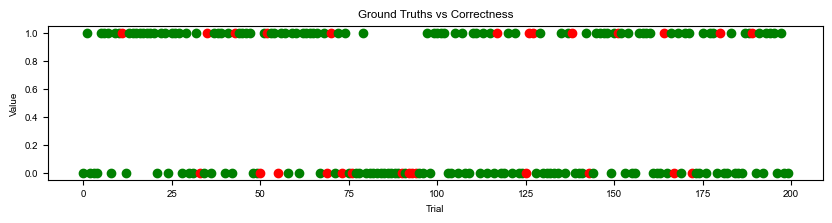

In [ ]:
# Extract ground truths and correctness from trial_infos
ground_truths = [info['ground_truth'] for info in trial_infos_plain.values()]
correctness = [info['correct'] for info in trial_infos_plain.values()]

# Plot ground truths against correctness
plt.figure(figsize=(10, 2))
for i,val in enumerate(ground_truths):
    if correctness[i] == 1:
        plt.plot(i,val, 'o', color='green')
    else:
        plt.plot(i,val, 'o', color='red')
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Ground Truths vs Correctness')
plt.show()


In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.828


#### Plain + noise

In [ ]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos_noisy = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = Noisy_net(inputs) # to-do

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos_noisy[i] = trial_info  # trial_info is a dictionary
    trial_infos_noisy[i].update({'correct': correct})
    

# Print information for sample trials
for i in range(5):
    print('Trial ', i, trial_infos_noisy[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos_noisy.values()]))

Trial  0 {'ground_truth': 0, 'coh': 12.8, 'correct': True}
Trial  1 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Trial  2 {'ground_truth': 0, 'coh': 6.4, 'correct': True}
Trial  3 {'ground_truth': 1, 'coh': 25.6, 'correct': True}
Trial  4 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Average performance 0.85


### Comparing learning curves

### Plotting functions
#### Combined plots

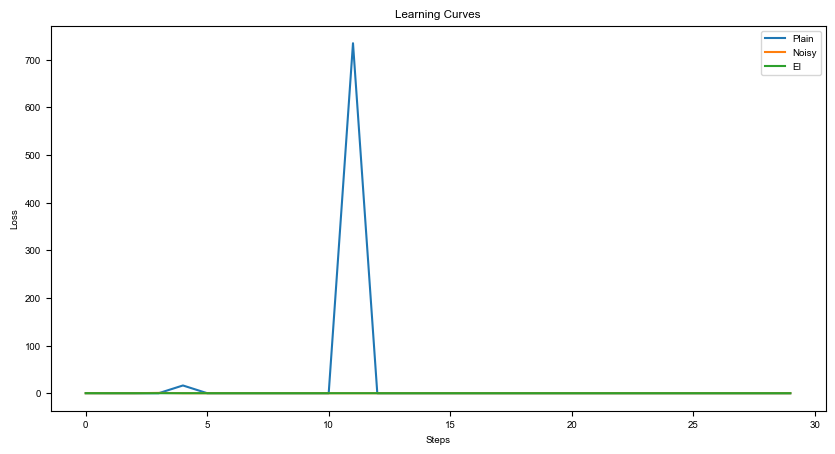

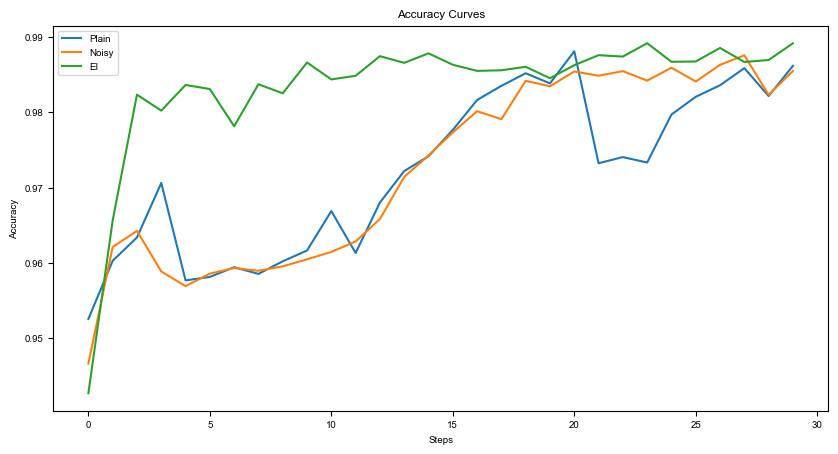

In [302]:
plt.figure(figsize=(10,5))
plt.title("Learning Curves")
plt.plot(leaky_loss_values, label='Plain')
plt.plot(noisy_loss_values, label='Noisy')
plt.plot(EI_loss_values, label='EI')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy Curves")
plt.plot(leaky_acc_values, label='Plain')
plt.plot(noisy_acc_values, label='Noisy')
plt.plot(EI_acc_values, label='EI')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Seperate Plots

In [303]:
def loss_accuracy(loss,accuracy):
    plt.figure()
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    
    ax[0].plot(loss)
    ax[0].set_title('Loss')
    ax[0].set_xticklabels(np.arange(len(loss)) * 100)
    ax[0].set_xlabel('Steps')
    # ax[0].set_ylim(0.05,0.1)
    ax[1].plot(accuracy)
    ax[1].set_title('Accuracy')
    ax[1].set_xticklabels(np.arange(len(accuracy)) * 100)
    ax[1].set_xlabel('Steps')
    plt.show()

C:\Users\Mahatma\AppData\Local\Temp\ipykernel_12876\2283150122.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(len(loss)) * 100)
C:\Users\Mahatma\AppData\Local\Temp\ipykernel_12876\2283150122.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.arange(len(accuracy)) * 100)


<Figure size 640x480 with 0 Axes>

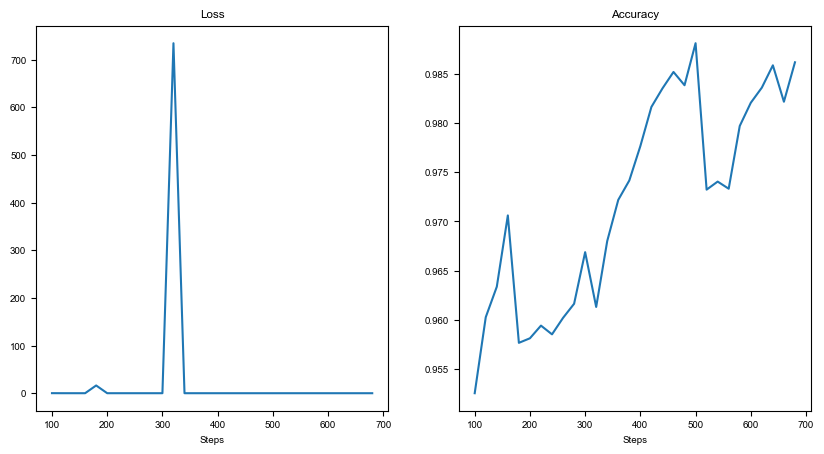

<Figure size 640x480 with 0 Axes>

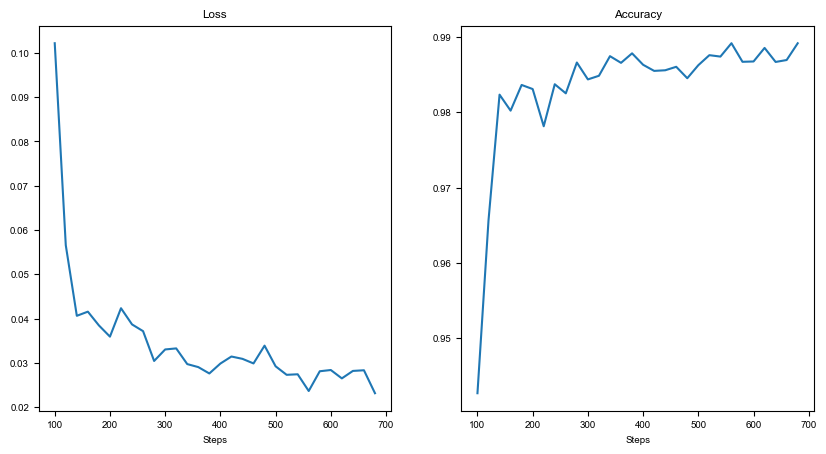

<Figure size 640x480 with 0 Axes>

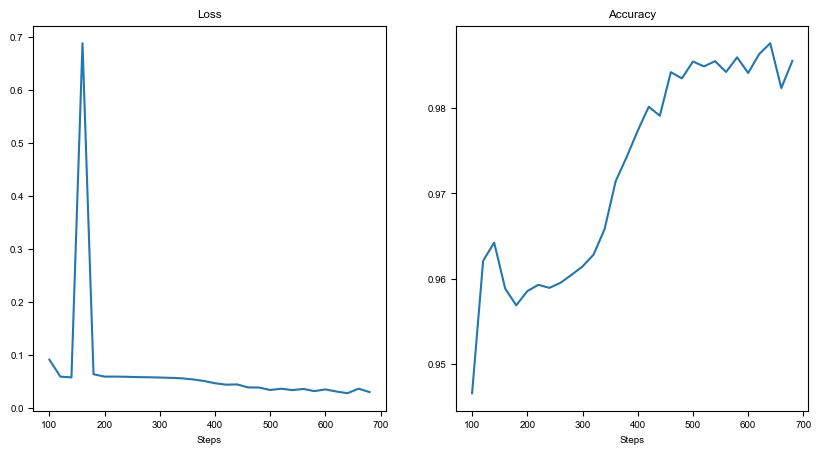

In [304]:
loss_accuracy(leaky_loss_values,leaky_acc_values)
loss_accuracy(EI_loss_values,EI_acc_values)
loss_accuracy(noisy_loss_values,noisy_acc_values)

## Part B
### What?
Using the models above, compare their abilities to perform a Neurogym task. 

### How to write
We need to compare how well they learn to perform the task including analysis of hidden layer activity. Compare this between the two models to see any differences.

## Part C
### What?
 

# Store

In [ ]:
def train_model(net, dataset, n_steps):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    plain_loss_values = []
    plain_acc_values = []
    plain_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(n_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output,_ = net(inputs) # might need need output,_
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss & accuracy every 100 steps
        plain_loss += loss.item()
        running_acc += (output.argmax(dim=1) == labels).float().mean().item()
        if i % 100 == 99:
            plain_loss /= 100
            print('Step {}, Loss {:0.4f}, Accuracy {:0.4f}, Time {:0.1f}s'.format(
                i+1, plain_loss, running_acc, time.time() - start_time))
            plain_loss_values.append(plain_loss)
            plain_acc_values.append(running_acc/100)
            running_acc = 0
            plain_loss = 0
    return net, plain_loss_values, plain_acc_values

Plain_net,plain_loss_values, plain_acc_values = general_train_model(net, dataset)

In [ ]:
from EI_model import EI_Net




#####################################################################
# @title Train the network on the decision making task

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = EI_Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

ei_loss_values = []  # List to store loss values
ei_acc_values = []  # List to store accuracy values
ei_loss = 0.0
ei_acc = 0.0
print_step = 100 # original 200
for i in range(2000): # original 5000
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    ei_loss += loss.item()
    ei_acc += (output.argmax(dim=1) == labels).float().mean().item()
    if i % print_step == (print_step - 1):
        average_loss = ei_loss / print_step
        average_acc = ei_acc / print_step
        print('Step {}, Loss {:0.4f}, Acc {:0.4f}'.format(i+1, average_loss, average_acc))
        ei_loss_values.append(average_loss)  # Append average loss here
        ei_acc_values.append(average_acc)
        ei_loss = 0.0
        ei_acc = 0.0


In [ ]:
from PlainNoisyLeaky import Plain_Noisy_RNNNet

# Canned environment from neurogym
# Copy the name of the Perceptual Decision Making environment from here: https://neurogym.github.io/envs/index.html
task_name = 'PerceptualDecisionMaking-v0'
# task_name = 'DelayPairedAssociation-v0'
# task_name = 'GoNogo-v0'
# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Make supervised dataset
seq_len = 100
batch_size = 16
#Create the dataset (Hover over ngym.Dataset to see input arguments)
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size = batch_size, seq_len = seq_len)
env = dataset.env

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n


# _ = ngym.utils.plot_env(env, num_trials=4)

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)


# Instantiate the network and print information
hidden_size = 50

# Create an instance of the Class RNNNet
net = Plain_Noisy_RNNNet(input_size, hidden_size, output_size)
# print(net)

def train_model(net, dataset,n_steps=2000):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    noisy_loss_values = []
    noisy_acc_values = []
    noisy_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(n_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output,_ = net(inputs) # might need need output,_
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        noisy_loss += loss.item()
        running_acc += (output.argmax(dim=1) == labels).float().mean().item()
        if i % 100 == 99:
            noisy_loss /= 100
            average_acc = running_acc / 100
            print('Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                i+1, noisy_loss, average_acc , time.time() - start_time))
            noisy_loss_values.append(noisy_loss)
            noisy_acc_values.append(average_acc)
            noisy_loss = 0
            running_acc = 0
    return net, noisy_loss_values, noisy_acc_values

Noisy_net,noisy_loss_values, noisy_acc_values = train_model(net, dataset)